## VARIATIONAL QUANTUM CLASSIFIER WITH QISKIT ##

In [1]:
#!pip install imblearn

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder, StandardScaler
import random
#import qiskit_ibm_runtime as IBMR
#from qiskit_ibm_runtime import QiskitRuntimeService

from sklearn import linear_model, svm
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap, RealAmplitudes

from qiskit.algorithms.optimizers import COBYLA, SPSA, SLSQP


from qiskit.primitives import Sampler

from qiskit_machine_learning.algorithms.classifiers import VQC  

from IPython.display import clear_output

from qiskit import BasicAer, execute

from qiskit_machine_learning.circuit.library import RawFeatureVector



/var/folders/72/24j7jy9s6sb2xm_dc84kdhm00000gn/T/ipykernel_40513/1736306243.py:20: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import COBYLA, SPSA, SLSQP


# TODO SPIEGAZIONE TEORICA DI VQC

In [3]:
random.seed(42)

In [4]:
file_path = "dataset/dataset.csv"

In [5]:
try:
    df = pd.read_csv(file_path)
    print("Dataset imported successfully.")
except FileNotFoundError:
    print("File not found. Please check the file path.")
    exit()

Dataset imported successfully.


In [6]:
df.drop(columns=['step'], inplace=True)
df.drop(columns=['zipcodeOri'], inplace=True)
df.drop(columns=['zipMerchant'], inplace=True)
df.drop(columns=['customer'], inplace=True)
df.drop(columns=['merchant'], inplace=True)

print(df.head())

   age gender             category  amount  fraud
0  '4'    'M'  'es_transportation'    4.55      0
1  '2'    'M'  'es_transportation'   39.68      0
2  '4'    'F'  'es_transportation'   26.89      0
3  '3'    'M'  'es_transportation'   17.25      0
4  '5'    'M'  'es_transportation'   35.72      0


In [7]:
encoder = LabelEncoder()

encoded_age = encoder.fit_transform(df['age'])
df['age'] = encoded_age
encoded_gender = encoder.fit_transform(df['gender'])
df['gender'] = encoded_gender
encoded_category = encoder.fit_transform(df['category'])
df['category'] = encoded_category

print(df.head())

   age  gender  category  amount  fraud
0    4       2        12    4.55      0
1    2       2        12   39.68      0
2    4       1        12   26.89      0
3    3       2        12   17.25      0
4    5       2        12   35.72      0


Undersampling to have a balanced dataset:

In [8]:
X = df.drop('fraud', axis=1)
y = df['fraud']

# Check class distribution
print("Class distribution before undersampling:")
print(y.value_counts())

#---------------------------------------------------------------------------
# To have only 100 fraud and 100 non-fraud samples
sampling_strategy = {0: 100, 1: 100}
#---------------------------------------------------------------------------

# Undersample the majority class
undersample = RandomUnderSampler(sampling_strategy=sampling_strategy)
X_resampled, y_resampled = undersample.fit_resample(X, y)

# Check class distribution after undersampling
print("Class distribution after undersampling:")
print(pd.Series(y_resampled).value_counts())

Class distribution before undersampling:
fraud
0    587443
1      7200
Name: count, dtype: int64
Class distribution after undersampling:
fraud
0    100
1    100
Name: count, dtype: int64


In [9]:
X_resampled = MinMaxScaler().fit_transform(X_resampled)

Train test split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=0)
print(X_train.shape, X_test.shape)

(140, 4) (60, 4)


To use the Amplitude encoding feature map we have to do a different data preprocessing:
In the amplitude encoding we want to encode our data in the amplitudes of our initial quantum state. To do so we need to make the size of the padded data point to match the size of the state vector in the quantum device.

In [11]:
num_examples, num_features = X_resampled.shape 

n = int(np.ceil(np.log2(num_features)))
dim = 2**n
print(f'(number of qubits, dimension of the Hilbert space) = {(n, dim)}')

zeros = np.zeros((num_examples, dim-num_features))
X_resampled_amp = np.append(X_resampled, zeros, axis=1)
num_examples, num_features = X_resampled_amp.shape
  
print("number of examples = ", num_examples)
print("number of features = ", num_features)

(number of qubits, dimension of the Hilbert space) = (2, 4)
number of examples =  200
number of features =  4


In [12]:
X_train_amp, X_test_amp, y_train_amp, y_test_amp = train_test_split(X_resampled_amp, y_resampled, test_size=0.3, random_state=0)

# QUANTUM FEATURE MAP:

Quantum feature maps are used to transform classical data into a quantum state that can be processed by a quantum computer. In a quantum feature map, the input data is transformed using a quantum gates operation to produce a new quantum state vector that contains higher-order correlations between the original data points 
$$\ket{\Psi(\vec{x})} = V_{\Phi(\vec{x})} \ket{0}^{\otimes N} $$
The quantum feature maps are able to efficiently generate complex transfor- mation that are computationally hard to construct using classical method. Moreover, the base quantum circuit operation can also be repeated multiple times to construct more complex feature maps.

# Pauli feature map

Pauli feature map is a class of feature maps, in general it transforms input data with $N$ features $\vec{x}\in \mathbb{R}^N$ into quantum information in $N$ qubits $\ket{\Psi(\vec{x})}$. It can be described as unitary operator below:
$$V_{\Phi(\vec{x})} = U_{\Phi(\vec{x})} H^{\otimes N}\dots  U_{\Phi(\vec{x})} H^{\otimes N}$$
$U_{\Phi(\vec{x})} H^{\otimes N}$ represents the Pauli expansion matrix:
$$U_{\Phi(\vec{x})} = e^{i\sum_{S\subseteq I}\alpha \psi_{S}(\vec{x})\prod_{j\in S}P_j}$$
where $I$ is the set of qubit indices describing the connections in the feature map and $\psi_{S}(\vec{x})$ is the data mapping function.
$$\psi_{S}(\vec{x}) =  \begin{cases} x_j \quad\quad & \text{if } S=\{x_j\} \\ \prod_{j\in S}(\pi - x_j) \quad\quad & \text{if } |S|>1 \end{cases} $$
$P_j \in \{I, X, Y, Z\}$ represents the Pauli matrices and \alpha is a variable to adjust the magnitude of Pauli rotation gates.
In the PauliFeatureMap class in Qiskit Python package we can specify the number of repetitions of the feature map to have more accurate representation; the entanglement type to represent the entanglement structure among qubits (linear, reverse linear, circular, full).

# ZZ feature map

The ZZ feature map is a second-order Pauli-Z evolution. It is only a special case of Pauli feature maps with Pauli sequence $[Z, ZZ]$ 

# TODO SPIEGAZIONE DELLA ZZ E LE ALTRE

We try different feature map to encode our data:

- PauliFeatureMap
- ZFeatureMap
- ZZFeatureMap
- Amplitude encoding

- PauliFeatureMap



/Users/edoardozappia/opt/anaconda3/envs/qiskit-stable/lib/python3.9/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


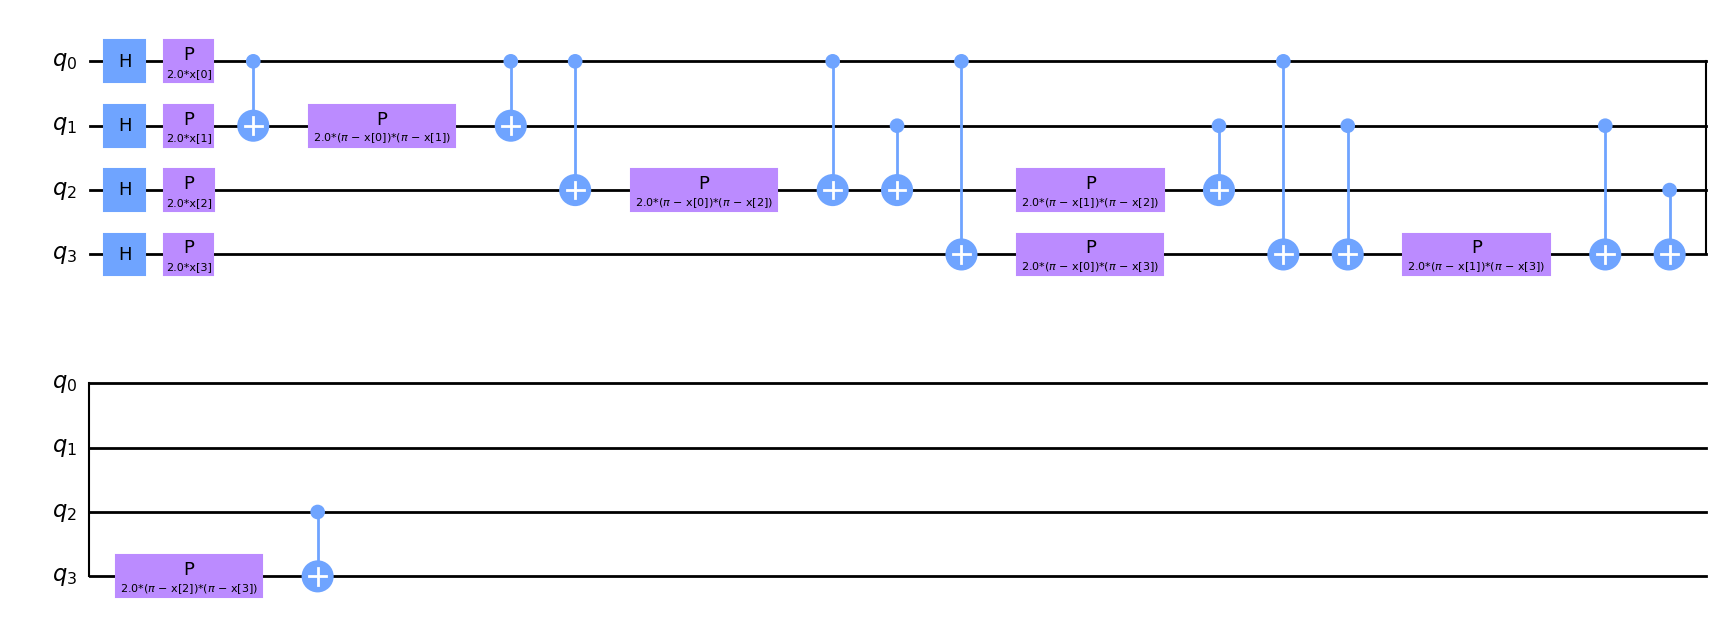

In [13]:
ZZ = ZZFeatureMap(feature_dimension=4, reps=1)   # feature_dimension = num_features       
ZZ.decompose().draw(output='mpl')

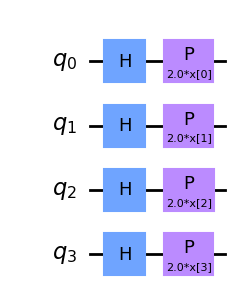

In [14]:
Z = ZFeatureMap(feature_dimension=4, reps=1)   # feature_dimension = num_features
Z.decompose().draw(output='mpl')

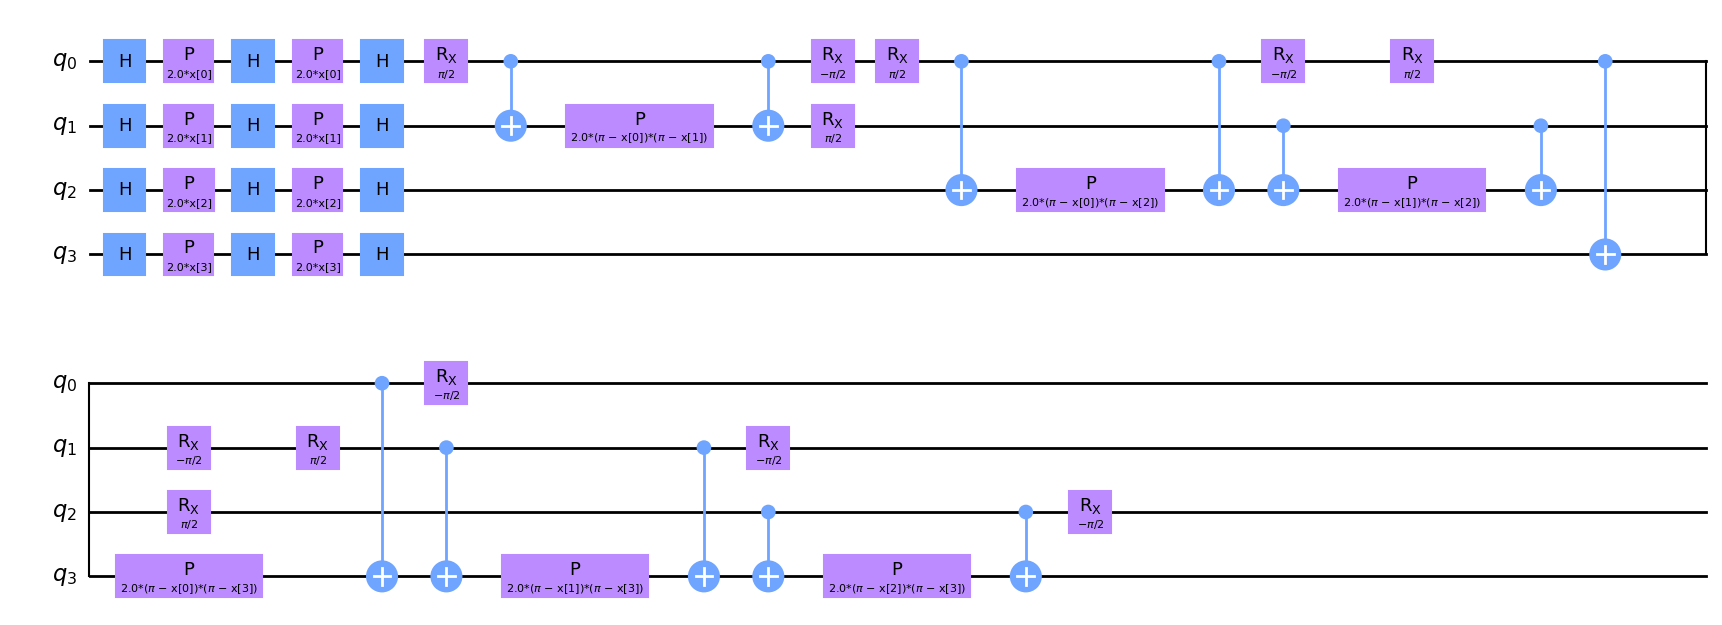

In [15]:
P = PauliFeatureMap(feature_dimension=4, reps=1, paulis=['Z','X','ZY'])   # feature_dimension = num_features
P.decompose().draw(output='mpl')

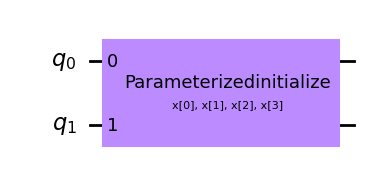

In [16]:
amp_enc = RawFeatureVector(feature_dimension=num_features) 
amp_enc.draw(output = 'mpl') 

Parametrized Quantum Circuits

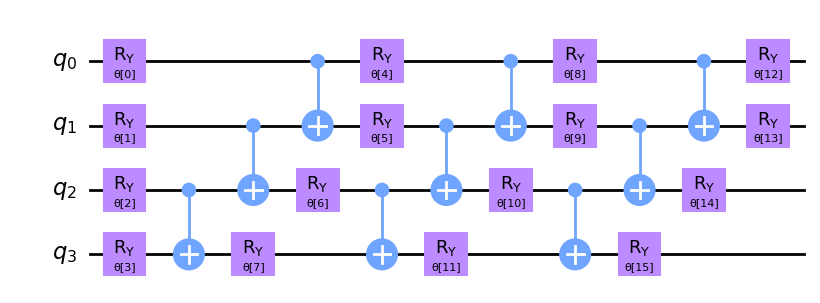

In [17]:
pqc = RealAmplitudes(num_qubits=4, reps=3)  # num_qubits = num_features
pqc.decompose().draw(output='mpl')

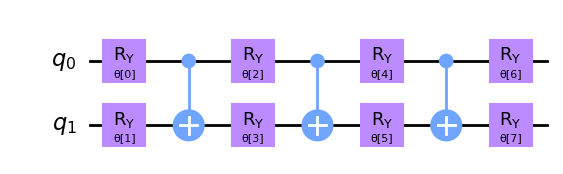

In [18]:
pqc_amp = RealAmplitudes(num_qubits=n, reps=3)
pqc_amp.decompose().draw(output = 'mpl')

There are three types of Optimizers:

- COBYLA (Constrained Optimization By Linear Approximation optimizer.)
- SPSA (Simultaneous Perturbation Stochastic Approximation optimizer.)
- SLSQP (Sequential Least Squares Programming optimize)

- COBYLA

COBYLA (Constrained Optimization BY Linear Approximation) is a gradient-free optimization algorithm that uses a linear approximation of the function in the neighborhood of the current point to determine the next point to evaluate. The algorithm is based on the idea of "trust regions," which means that the algorithm only considers changes to the variables that are within a certain "trust region" around the current point. It is particularly useful when the objective function is expensive to evaluate or is non-differentiable. It is also well-suited for problems with constraints, as it can handle both equality and inequality constraints.
The COBYLA algorithm has two important parameters: rhobeg and maxiter. rhobeg determines the size of the initial "trust region" around the starting point, and maxiter specifies the maximum number of iterations the algorithm can perform before terminating. In general, smaller values of rhobeg will lead to more accurate results, but may also increase the computational cost of the algorithm.

- SPSA

SPSA is a general method for minimizing differentiable multivariate functions. It is particularly useful for functions for which evaluating the gradient is not possible, or too resource intensive. SPSA provides a stochastic method for approximating the gradient of the cost function. To accomplish this, the cost function is evaluated twice using perturbed parameter vectors: every component of the original parameter vector is simultaneously shifted with a randomly generated value. This is in contrast to finite-differences methods where for each evaluation only one component of the parameter vector is shifted at a time.

- SLSQP

SLSQP optimizer is a sequential least squares programming algorithm which uses the Han-Powell quasi-Newton method with a BFGS update of the B-matrix and an L1-test function in the step-length algorithm. The optimizer uses a slightly modified version of Lawson and Hanson’s NNLS nonlinear least-squares solver.

In [19]:
optimizer = COBYLA(maxiter=100)
#service = QiskitRuntimeService()
#backend = service.get_backend("simulator_statevector")
#sampler = IBMR.Sampler(backend=backend)
sampler = Sampler()

initial_point_amp=np.random.random(pqc_amp.num_parameters)

initial_point=np.random.random(pqc.num_parameters)

objective_func_vals = {'Z': [], 'ZZ': [], 'P': [], 'Amp': []}

def callback(feature_map_name, obj_func_eval):
    # Append objective function value to the corresponding list based on the feature map name
    objective_func_vals[feature_map_name].append(obj_func_eval)

def plot_objective_function_values():
    clear_output(wait=True)
    
    # Plot all objective function values
    
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    for feature_map_name, obj_func_vals in objective_func_vals.items():
        plt.plot(range(len(obj_func_vals)), obj_func_vals, label=feature_map_name)
    plt.legend()
    plt.show()

# In Qiskit, the default loss function is cross entropy

vqc_Z = VQC(
    sampler=sampler,
    feature_map=Z,
    ansatz=pqc,
    initial_point=initial_point,
    optimizer=optimizer,
    callback=lambda weights, obj_func_eval: callback('Z', obj_func_eval),
)

vqc_ZZ = VQC(
    sampler=sampler,
    feature_map=ZZ,
    ansatz=pqc,
    initial_point=initial_point,
    optimizer=optimizer,
    callback=lambda weights, obj_func_eval: callback('ZZ', obj_func_eval),
)

vqc_P = VQC(
    sampler=sampler,
    feature_map=P,
    ansatz=pqc,
    initial_point=initial_point,
    optimizer=optimizer,
    callback=lambda weights, obj_func_eval: callback('P', obj_func_eval),
)

vqc_amp = VQC(
    sampler=sampler,
    feature_map=amp_enc,
    ansatz=pqc_amp,
    initial_point=initial_point_amp,
    optimizer=optimizer,
    callback=lambda weights, obj_func_eval: callback('Amp', obj_func_eval),
)

In [20]:
# vqc.fit wants ndarray as input

y_train_np = y_train.values
y_test_np = y_test.values

y_train_np_amp = y_train_amp.values
y_test_np_amp = y_test_amp.values

In [21]:
%%time
vqc_Z.fit(X_train, y_train_np)

CPU times: user 2min 18s, sys: 833 ms, total: 2min 18s
Wall time: 2min 20s


In [22]:
%%time
vqc_ZZ.fit(X_train, y_train_np)

CPU times: user 3min 31s, sys: 1 s, total: 3min 32s
Wall time: 3min 34s


In [23]:
%%time
vqc_P.fit(X_train, y_train_np)

CPU times: user 4min 13s, sys: 1.29 s, total: 4min 14s
Wall time: 4min 16s


In [24]:
%%time
vqc_amp.fit(X_train_amp, y_train_np_amp)

CPU times: user 1min 11s, sys: 488 ms, total: 1min 12s
Wall time: 1min 12s


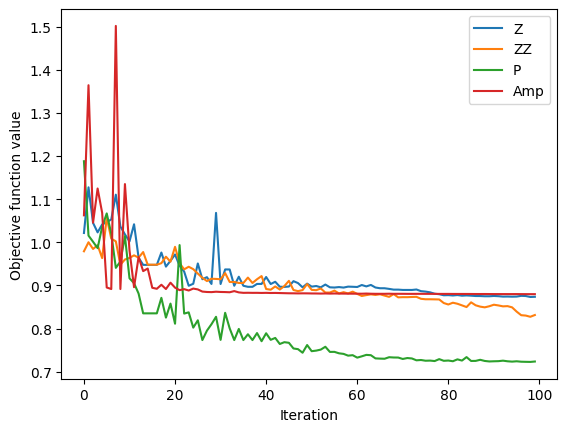

In [25]:
# Plot the objective function values after all fits

plot_objective_function_values()

In [26]:
def evaluate_with_feature_map(vqc, X_train, y_train, X_test, y_test, feature_map_name):
    # Perform predictions on training and test sets
    y_train_pred = vqc.predict(X_train)
    y_test_pred = vqc.predict(X_test)
    
    # Print classification report and confusion matrix for training set
    print(f"Classification Report for {feature_map_name} Feature Map (Train Set):\n")
    print(classification_report(y_train_np, y_train_pred))
    print("Confusion Matrix for Train Set:")
    print(confusion_matrix(y_train_np, y_train_pred))
    print("\n")
    
    # Print classification report and confusion matrix for test set
    print(f"Classification Report for {feature_map_name} Feature Map (Test Set):\n")
    print(classification_report(y_test_np, y_test_pred))
    print("Confusion Matrix for Test Set:")
    print(confusion_matrix(y_test_np, y_test_pred))
    
    # Print ROC AUC score for test set
    print(f"ROC AUC Score for {feature_map_name} Feature Map (Test Set):")
    print(round(roc_auc_score(y_test_np, y_test_pred), 4))
    print(70*'=')

In [27]:
vqc_models = {'Z': vqc_Z, 'ZZ': vqc_ZZ, 'P': vqc_P, 'Amp': vqc_amp}

for feature_map_name, vqc_model in vqc_models.items():
    print(f"Evaluating performance for {feature_map_name} Feature Map:\n")
    if feature_map_name == 'Amp':
        evaluate_with_feature_map(vqc_amp, X_train_amp, y_train_np_amp, X_test_amp, y_test_np_amp, feature_map_name)
    else:
    # Perform predictions and evaluate performance metrics
        evaluate_with_feature_map(vqc_model, X_train, y_train_np, X_test, y_test_np, feature_map_name)

Evaluating performance for Z Feature Map:

Classification Report for Z Feature Map (Train Set):

              precision    recall  f1-score   support

           0       0.69      0.83      0.75        71
           1       0.78      0.61      0.68        69

    accuracy                           0.72       140
   macro avg       0.73      0.72      0.72       140
weighted avg       0.73      0.72      0.72       140

Confusion Matrix for Train Set:
[[59 12]
 [27 42]]


Classification Report for Z Feature Map (Test Set):

              precision    recall  f1-score   support

           0       0.70      0.90      0.79        29
           1       0.87      0.65      0.74        31

    accuracy                           0.77        60
   macro avg       0.79      0.77      0.76        60
weighted avg       0.79      0.77      0.76        60

Confusion Matrix for Test Set:
[[26  3]
 [11 20]]
ROC AUC Score for Z Feature Map (Test Set):
0.7709
Evaluating performance for ZZ Feature Map:

AUC (100 iterations, 140 training samples, 60 testing samples):

- COBYLA:       'Z' 0.7709;     'ZZ' 0.7063;     'P' 0.7075;      'Amp' 0.8526

- SPSA:         'Z' 0.7397;     'ZZ' 0.7836;     'P' 0.7063;      'Amp' 0.5868     more time to compute than COBYLA

- SLSQP:        too much time

# TODO CONFRONTO RISULTATI

Now we try different classical machine learning models

In [28]:
%%time

def train_test(ML_model):
    print(20*' ', ML_model,'\n')
    ML_model.fit(X_train, y_train_np)                         
    
    y_train_pred = ML_model.predict(X_train)       
    y_test_pred = ML_model.predict(X_test)
    
    
    print(classification_report(y_train_np, y_train_pred))
    print("Confusion Matrix for Train Set:")    
    print(confusion_matrix(y_train_np, y_train_pred))

    print(classification_report(y_test_np, y_test_pred))
    print("Confusion Matrix for Test Set:")
    print(confusion_matrix(y_test_np, y_test_pred))
    print(f"ROC AUC Score (Test Set):")
    print(round(roc_auc_score(y_test_np, y_test_pred),2))
    
    print(70*'=')
    
print(70*'=')
ML_model = linear_model.LogisticRegression()         
train_test(ML_model)


ML_model = MLPClassifier()                            
train_test(ML_model)


ML_model = svm.SVC() 
train_test(ML_model)


ML_model = RandomForestClassifier()
train_test(ML_model)


                     LogisticRegression() 

              precision    recall  f1-score   support

           0       0.78      0.83      0.80        71
           1       0.81      0.75      0.78        69

    accuracy                           0.79       140
   macro avg       0.79      0.79      0.79       140
weighted avg       0.79      0.79      0.79       140

Confusion Matrix for Train Set:
[[59 12]
 [17 52]]
              precision    recall  f1-score   support

           0       0.77      0.93      0.84        29
           1       0.92      0.74      0.82        31

    accuracy                           0.83        60
   macro avg       0.85      0.84      0.83        60
weighted avg       0.85      0.83      0.83        60

Confusion Matrix for Test Set:
[[27  2]
 [ 8 23]]
ROC AUC Score (Test Set):
0.84
                     MLPClassifier() 



/Users/edoardozappia/opt/anaconda3/envs/qiskit-stable/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.77      0.82      0.79        71
           1       0.80      0.75      0.78        69

    accuracy                           0.79       140
   macro avg       0.79      0.79      0.79       140
weighted avg       0.79      0.79      0.79       140

Confusion Matrix for Train Set:
[[58 13]
 [17 52]]
              precision    recall  f1-score   support

           0       0.79      0.93      0.86        29
           1       0.92      0.77      0.84        31

    accuracy                           0.85        60
   macro avg       0.86      0.85      0.85        60
weighted avg       0.86      0.85      0.85        60

Confusion Matrix for Test Set:
[[27  2]
 [ 7 24]]
ROC AUC Score (Test Set):
0.85
                     SVC() 

              precision    recall  f1-score   support

           0       0.86      0.83      0.84        71
           1       0.83      0.86      0.84        69

    accuracy         

# TODO CONFRONTO CON MODELLI CLASSICI E CONSIDERAZIONI